In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split


In [2]:
# 设置包含数据文件的目录路径
data_directory = r"C:\Users\ASUS\Desktop\school\project\poseture\KeypointsWithoutFalldown"

# 创建一个列表来存储数据
data = []
labels = []

# 遍历目录中的所有 .npy 文件
for filename in os.listdir(data_directory):
    if filename.endswith('.npy'):
        # 加载 .npy 文件
        file_path = os.path.join(data_directory, filename)
        keypoints_data = np.load(file_path)
        
        # 根據檔名來判斷類別
        if filename.startswith('standing'):
            label = 0
        elif filename.startswith('sitting'):
            label = 1
        elif filename.startswith('lying'):
            label = 2
        else:
            continue  # 如果檔名不符合任何已知的模式，則忽略該檔案
        
        # 将数据添加到列表中
        keypoints_data = np.squeeze(keypoints_data, axis=0)  # 去除额外的维度
        data.append(keypoints_data)
        labels.append(label)

# 将列表转换为 NumPy 数组
data = np.array(data)
labels = np.array(labels)

# 将数据展平为 (360, 17*3)
# data = data.reshape(data.shape[0], -1)


In [3]:
print(data.shape)

(2320, 1, 17, 3)


In [4]:
# 切分数据集为训练集和测试集
test_size = 0.2  # 指定测试集的比例
random_state = 42  # 随机种子，可选
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)

# 調整 X_train 和 X_test 的形狀以適應模型的輸入層
# X_train = X_train.reshape(X_train.shape[0], 1, 17, 3)
# X_test = X_test.reshape(X_test.shape[0], 1, 17, 3)


model = models.Sequential([
    layers.Conv2D(32, (2, 2), activation='relu', input_shape=(1, 17, 3), padding='same'),
    layers.MaxPooling2D((1, 2), strides=(1, 1)),
    layers.Conv2D(64, (2, 2), activation='relu', padding='same'),
    layers.MaxPooling2D((1, 2), strides=(1, 1)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 17, 32)         416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 16, 32)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 16, 64)         8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 15, 64)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 128)               1

In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # 适合分类任务的损失函数
              metrics=['accuracy'])


In [7]:
# 訓練模型
train_history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
58/58 [==============================] - 1s 9ms/step - loss: 1.0378 - accuracy: 0.4768 - val_loss: 0.9753 - val_accuracy: 0.4935
Epoch 2/10
58/58 [==============================] - 0s 5ms/step - loss: 0.8765 - accuracy: 0.6180 - val_loss: 0.7834 - val_accuracy: 0.6746
Epoch 3/10
58/58 [==============================] - 0s 5ms/step - loss: 0.6905 - accuracy: 0.7026 - val_loss: 0.5902 - val_accuracy: 0.7608
Epoch 4/10
58/58 [==============================] - 0s 5ms/step - loss: 0.5152 - accuracy: 0.8109 - val_loss: 0.4719 - val_accuracy: 0.8211
Epoch 5/10
58/58 [==============================] - 0s 5ms/step - loss: 0.4421 - accuracy: 0.8227 - val_loss: 0.4476 - val_accuracy: 0.8341
Epoch 6/10
58/58 [==============================] - 0s 5ms/step - loss: 0.3733 - accuracy: 0.8658 - val_loss: 0.3819 - val_accuracy: 0.8470
Epoch 7/10
58/58 [==============================] - 0s 5ms/step - loss: 0.3043 - accuracy: 0.8987 - val_loss: 0.3205 - val_accuracy: 0.8728
Epoch 8/10
58/58 [==

In [8]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

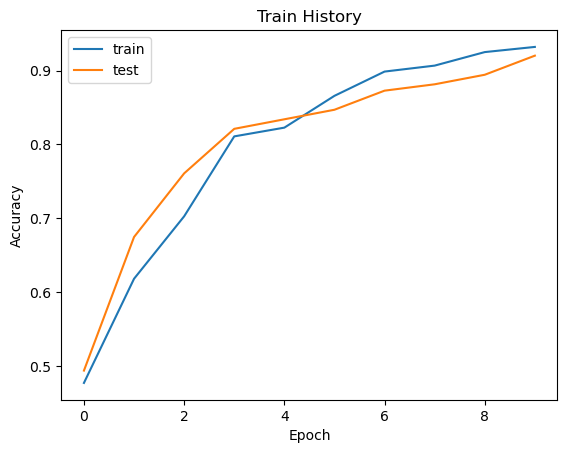

In [9]:
show_train_history('accuracy','val_accuracy')

In [10]:
# 儲存模型
model.save(r"C:\Users\ASUS\Desktop\school\project\model\best3poseturemodel")

INFO:tensorflow:Assets written to: C:\Users\ASUS\Desktop\school\project\model\best3poseturemodel\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\Desktop\school\project\model\best3poseturemodel\assets


In [11]:
import cv2 
from tensorflow.keras.models import load_model

# 加載模型
model = load_model(r"C:\Users\ASUS\Desktop\school\project\model\testModel")
interpreter = tf.lite.Interpreter(model_path=r"C:\Users\ASUS\Desktop\school\project\TFLiteMovenet\lite-model_movenet_singlepose_lightning_3.tflite")
interpreter.allocate_tensors()

# 定義圖片路徑
image_path = r"C:\Users\ASUS\Desktop\school\project\poseture\lying\lying72.jpg"

image_height = 192
image_width = 192
# 讀取圖片
image = cv2.imread(image_path)

image = tf.image.resize_with_pad(image, image_height, image_width)
input_image = tf.cast(image, dtype=tf.float32)

#Setup input and output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_image = np.expand_dims(input_image, axis=0)  # 添加批次维度
interpreter.set_tensor(input_details[0]["index"], input_image)
interpreter.invoke()
keypoints_with_scores = interpreter.get_tensor(output_details[0]["index"])

now_input = keypoints_with_scores
print(now_input.shape)

# 使用模型進行預測
predictions = model.predict(now_input)

# predictions 是一個包含每個類別預測概率的數組，我們可以使用 argmax 來獲得最大概率的索引
predicted_class = np.argmax(predictions)

# 打印預測結果
if predicted_class == 0:
    predicted_class = 'standing'
elif predicted_class == 1:
    predicted_class = 'sitting'
elif predicted_class == 2:
    predicted_class = 'lying'
elif predicted_class == 3:
    predicted_class = 'falldown'
print(f'The model predicts that the image is {predicted_class}.')

(1, 1, 17, 3)
1/1 [==============================] - 0s 118ms/step
The model predicts that the image is standing.
